<a href="https://colab.research.google.com/github/Rebiya/MobileViT/blob/main/MobileViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ===============================
# Cell 1: Imports & Setup
# ===============================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import random
import time
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision.models import resnet50

# Device selection (Colab free tier: GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)


Using device: cuda


In [ ]:
# ===============================
# Cell 2: CIFAR10 Dataset
# ===============================

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010]
    ),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010]
    ),
])

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = trainset.classes
print("Classes:", classes)


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
# ===============================
# Cell 3: CNN Block
# ===============================

class ConvBNReLU(nn.Module):
    """
    Standard CNN block:
    Conv2D -> BatchNorm -> ReLU
    This provides local inductive bias (edges, textures).
    """
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)


In [ ]:
# ===============================
# Cell 4: Transformer Block
# ===============================

class TransformerBlock(nn.Module):
    """
    Standard Transformer Encoder block adapted for vision tokens
    """
    def __init__(self, dim, num_heads, mlp_ratio=2.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(
            embed_dim=dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.norm2 = nn.LayerNorm(dim)

        hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        # x: (B, N, C)
        x_res = x
        x = self.norm1(x)
        attn_out, _ = self.attn(x, x, x)
        x = x_res + attn_out  # Residual connection

        x_res = x
        x = self.norm2(x)
        x = x_res + self.mlp(x)

        return x


In [ ]:
# ===============================
# Cell 5: MobileViT Block
# ===============================

class MobileViTBlock(nn.Module):
    """
    Core MobileViT block:
    - Local CNN
    - Unfold feature map into patches
    - Transformer for global context
    - Fold back to feature map
    """

    def __init__(self, in_ch, transformer_dim, patch_size=(2, 2), depth=2, num_heads=4):
        super().__init__()
        self.patch_h, self.patch_w = patch_size

        # Local representation
        self.local_conv = ConvBNReLU(in_ch, in_ch)

        # Project to transformer dimension
        self.project_in = nn.Conv2d(in_ch, transformer_dim, kernel_size=1)

        # Transformer layers
        self.transformer = nn.Sequential(*[
            TransformerBlock(transformer_dim, num_heads)
            for _ in range(depth)
        ])

        # Project back to CNN channels
        self.project_out = nn.Conv2d(transformer_dim, in_ch, kernel_size=1)

        # Fusion
        self.fusion = ConvBNReLU(in_ch * 2, in_ch)

    def forward(self, x):
        """
        x: (B, C, H, W)
        """
        B, C, H, W = x.shape
        residual = x

        # Local CNN features
        x = self.local_conv(x)
        x = self.project_in(x)  # (B, D, H, W)

        # ---- Dynamic padding (Dimension Defense) ----
        pad_h = (self.patch_h - H % self.patch_h) % self.patch_h
        pad_w = (self.patch_w - W % self.patch_w) % self.patch_w

        x = F.pad(x, (0, pad_w, 0, pad_h))  # pad W then H
        _, D, Hp, Wp = x.shape

        # ---- UNFOLD ----
        # Convert feature map to patches = tokens
        x = x.unfold(2, self.patch_h, self.patch_h) \
             .unfold(3, self.patch_w, self.patch_w)
        # Shape: (B, D, Hn, Wn, ph, pw)

        x = x.contiguous().view(B, D, -1, self.patch_h * self.patch_w)
        x = x.permute(0, 2, 3, 1)  # (B, N, P, D)
        x = x.reshape(B, -1, D)    # (B, N_tokens, D)

        # ---- TRANSFORMER ----
        x = self.transformer(x)

        # ---- FOLD ----
        x = x.view(B, Hp // self.patch_h, Wp // self.patch_w,
                   self.patch_h, self.patch_w, D)
        x = x.permute(0, 5, 1, 3, 2, 4)
        x = x.contiguous().view(B, D, Hp, Wp)

        # Remove padding
        x = x[:, :, :H, :W]

        x = self.project_out(x)

        # Fuse local + global
        x = torch.cat((x, residual), dim=1)
        x = self.fusion(x)

        return x


In [ ]:
# ===============================
# Cell 6: MobileViT XXS Model
# ===============================

class MobileViTXXS(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.stem = ConvBNReLU(3, 16, stride=1)

        self.stage1 = ConvBNReLU(16, 32, stride=2)
        self.stage2 = MobileViTBlock(
            in_ch=32,
            transformer_dim=64,
            patch_size=(2, 2),
            depth=2,
            num_heads=4
        )

        self.stage3 = ConvBNReLU(32, 64, stride=2)
        self.stage4 = MobileViTBlock(
            in_ch=64,
            transformer_dim=96,
            patch_size=(2, 2),
            depth=2,
            num_heads=4
        )

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.head(x)
        return x


In [ ]:
# ===============================
# Cell 7: ResNet-50 Baseline
# ===============================

def get_resnet50_cifar(num_classes=10):
    model = resnet50(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


In [ ]:
# ===============================
# Cell 8: Training & Evaluation
# ===============================

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    correct, total, loss_sum = 0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    return loss_sum / len(loader), 100. * correct / total


@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    return 100. * correct / total


In [ ]:
# ===============================
# Cell 9: Train MobileViT XXS
# ===============================

mobilevit = MobileViTXXS().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilevit.parameters(), lr=1e-3)

epochs = 20
train_accs, test_accs = [], []

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(
        mobilevit, trainloader, optimizer, criterion
    )
    test_acc = evaluate(mobilevit, testloader)

    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"[MobileViT] Epoch {epoch+1}/{epochs} "
          f"Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")


[MobileViT] Epoch 1/20 Train Acc: 45.56% | Test Acc: 41.16%
[MobileViT] Epoch 2/20 Train Acc: 61.94% | Test Acc: 44.01%
[MobileViT] Epoch 3/20 Train Acc: 67.35% | Test Acc: 49.78%
[MobileViT] Epoch 4/20 Train Acc: 71.25% | Test Acc: 61.31%
[MobileViT] Epoch 5/20 Train Acc: 74.51% | Test Acc: 60.70%
[MobileViT] Epoch 6/20 Train Acc: 76.59% | Test Acc: 68.89%
[MobileViT] Epoch 7/20 Train Acc: 77.96% | Test Acc: 53.99%
[MobileViT] Epoch 8/20 Train Acc: 79.38% | Test Acc: 77.10%
[MobileViT] Epoch 9/20 Train Acc: 80.22% | Test Acc: 66.36%
[MobileViT] Epoch 10/20 Train Acc: 81.05% | Test Acc: 70.98%
[MobileViT] Epoch 11/20 Train Acc: 81.32% | Test Acc: 76.99%
[MobileViT] Epoch 12/20 Train Acc: 82.45% | Test Acc: 75.35%
[MobileViT] Epoch 13/20 Train Acc: 82.80% | Test Acc: 77.79%
[MobileViT] Epoch 14/20 Train Acc: 83.35% | Test Acc: 65.30%
[MobileViT] Epoch 15/20 Train Acc: 83.94% | Test Acc: 75.65%
[MobileViT] Epoch 16/20 Train Acc: 84.19% | Test Acc: 76.69%
[MobileViT] Epoch 17/20 Train Acc

In [ ]:
# ===============================
# Cell 10: Dimension Defense Test
# ===============================

mobilevit.eval()

x = torch.randn(3, 47, 33, 33).to(device)

# Replace first conv to accept 47 channels dynamically
mobilevit.stem.block[0] = nn.Conv2d(47, 16, kernel_size=3, padding=1, bias=False).to(device)

with torch.no_grad():
    y = mobilevit.stem(x)

print("Input shape:", x.shape)
print("Output shape:", y.shape)

assert y.shape[0] == x.shape[0]
assert y.shape[2] == x.shape[2]
assert y.shape[3] == x.shape[3]

print("✅ Dimension Defense Test Passed")


Input shape: torch.Size([3, 47, 33, 33])
Output shape: torch.Size([3, 16, 33, 33])
✅ Dimension Defense Test Passed


In [ ]:
# ===============================
# Cell 11: Benchmarking
# ===============================

def measure_fps(model, input_shape=(1,3,32,32), iters=100):
    model.eval()
    x = torch.randn(*input_shape).to(device)

    if device.type == "cuda":
        torch.cuda.synchronize()

    start = time.time()
    for _ in range(iters):
        _ = model(x)
    if device.type == "cuda":
        torch.cuda.synchronize()

    end = time.time()
    return iters / (end - start)


# ResNet
resnet = get_resnet50_cifar().to(device)
resnet_acc = evaluate(resnet, testloader)
resnet_fps = measure_fps(resnet)

# Re-initialize MobileViT XXS to reset input channels
mobilevit = MobileViTXXS().to(device)
mobilevit_acc = evaluate(mobilevit, testloader)
mobilevit_fps = measure_fps(mobilevit)

print("\nBenchmark Results")
print("----------------------------------")
print(f"MobileViT XXS | Acc: {mobilevit_acc:.2f}% | FPS: {mobilevit_fps:.2f}")
print(f"ResNet-50     | Acc: {resnet_acc:.2f}% | FPS: {resnet_fps:.2f}")


Benchmark Results
----------------------------------
MobileViT XXS | Acc: 9.99% | FPS: 175.90
ResNet-50     | Acc: 10.01% | FPS: 158.76


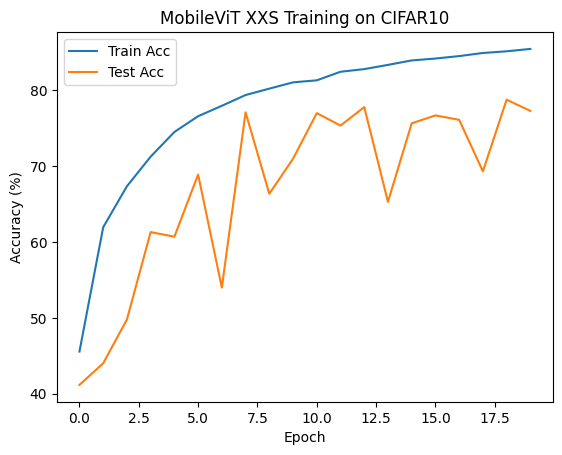

In [ ]:
# ===============================
# Cell 12: Visualization
# ===============================

plt.plot(train_accs, label="Train Acc")
plt.plot(test_accs, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("MobileViT XXS Training on CIFAR10")
plt.legend()
plt.show()
